In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Prepare the Data

In [2]:
def strip_dollar(s):
    '''
    convert price string with dollar notation to float like '$1,250'
    '''
    if s == '':
        return np.NaN
    return np.float(s.replace('$', '').replace(',', ''))

In [3]:
# Calendar
seattle_cal = pd.read_csv('./data/seattle/calendar.csv', 
                          index_col='date', parse_dates=['date'], converters={'price':strip_dollar})
boston_cal = pd.read_csv('./data/boston/calendar.csv', 
                          index_col='date', parse_dates=['date'], converters={'price':strip_dollar})
# Listings
seattle_list = pd.read_csv('./data/seattle/listings.csv', converters={'price':strip_dollar})
boston_list = pd.read_csv('./data/boston/listings.csv', converters={'price':strip_dollar})

# choose columns
seattle_list = seattle_list[['id', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']]
boston_list = boston_list[['id', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price']]

In [4]:
# Calendar price
boston_cal_price = boston_cal[boston_cal['available'] == 't'][['listing_id', 'price']]
seattle_cal_price = seattle_cal[seattle_cal['available'] == 't'][['listing_id', 'price']]

# Boston Price Calendar
Let's take a look at the day-to-day changes in the mean price of Boston

In [5]:
boston_price_d = boston_cal_price['price'].resample('D')

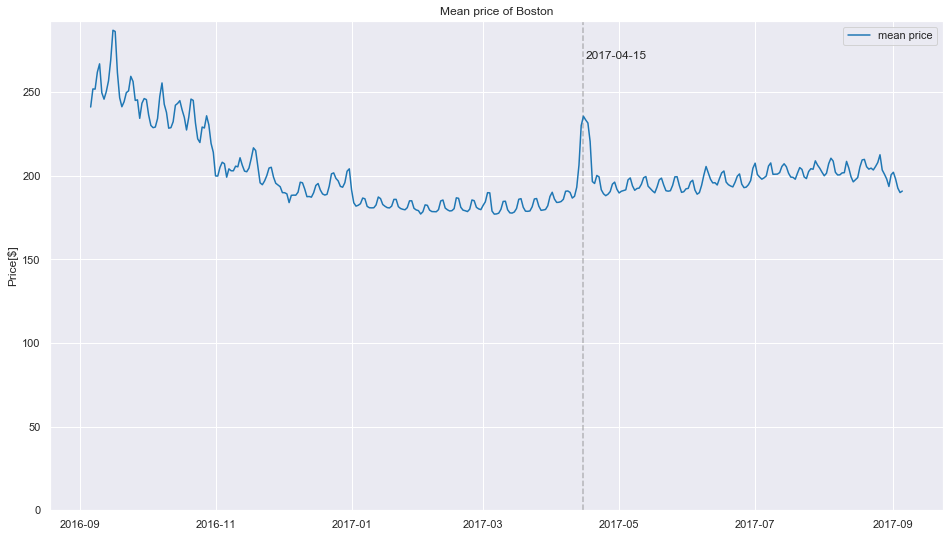

In [6]:
plt.figure(figsize=(16, 9))
plt.title('Mean price of Boston')
plt.plot(boston_price_d.mean(), label='mean price', color='tab:blue')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.ylabel('Price[$]')
plt.vlines('2017-04-15', 0, ymax, linestyle='--', color='tab:gray', alpha=0.5)
plt.gca().annotate('2017-04-15', xy=('2017-04-16', 270))
plt.legend()
plt.show()

## Observation of Boston price
* Prices are dropping rapidly over 2017-01.
* After that, there is a slow upward trend.
* But, there are price peak around 2017-04-15~2017-04-17.
* And, periodic small peaks are observed.

# Question 0: What is small periodic small peaks and one big peak

## About periodic peaks
It's a weekly period of Fridy and Saturaday<br>
It seems natural that weekend room rates would go up.

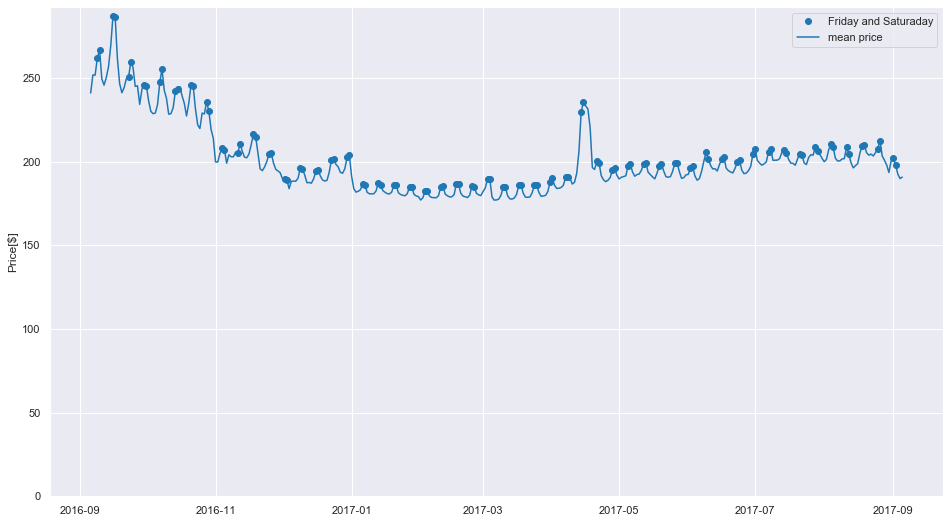

In [7]:
plt.figure(figsize=(16, 9))
boston_mean = boston_price_d.mean()
plt.plot(boston_mean[boston_mean.index.weekday.isin([4, 5])], 
         marker='o', linewidth=0, color='tab:blue', label='Friday and Saturaday')
plt.plot(boston_mean, color='tab:blue', label='mean price')
plt.legend()
plt.ylim(0, ymax)
plt.ylabel('Price[$]')
plt.show()

## What is the big peak at 2017-04
I googled to see if there were any major events in Boston in April 2017.<br>
Then I found Boston Marathon was held at April 17.<br>
May be it's a cause of price peak of 2017-04-14 to 2017-04-16.

# Question 1: What rooms raised their prices during the event?
I've found that prices go up depending on the event.<br>
I wonder if all the rooms will have their prices increased, or just some of them.

In [8]:
# max price during 2017-04-14 to 2017-04-17
boston_cal_price_max = boston_cal_price['2017-04-14':'2017-04-17'].groupby('listing_id').max()

In [9]:
# difference between listing price and calendar price
boston_price_diff = boston_cal_price_max.reset_index().merge(boston_list[['id', 'price']], 
                                         left_on='listing_id', right_on='id', suffixes=['_after', '_before'])
boston_price_diff['diff'] = boston_price_diff['price_after'] - boston_price_diff['price_before']

## Mean price of listing and during event

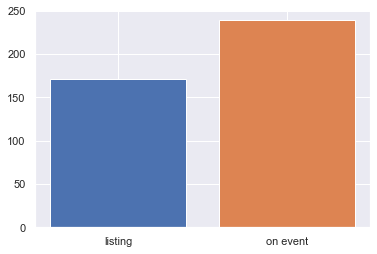

In [10]:
plt.bar(['listing'], [boston_price_diff['price_before'].mean()])
plt.bar(['on event'], [boston_price_diff['price_after'].mean()])
plt.show()

## Distribution of price

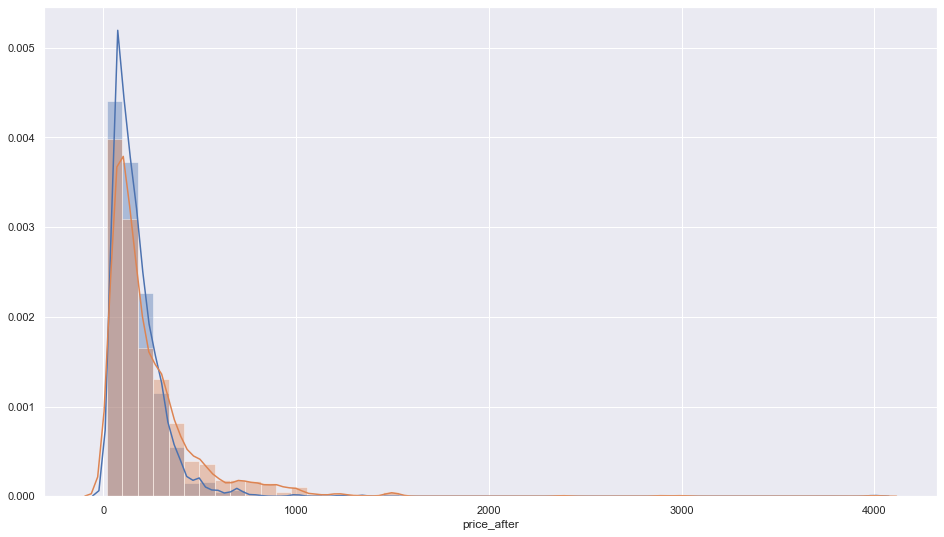

In [11]:
plt.figure(figsize=(16, 9))
sns.distplot(boston_price_diff['price_before'], label='listing')
sns.distplot(boston_price_diff['price_after'], label='on event')
plt.show()

It seems the higher price are increasing.

## Check the quartile

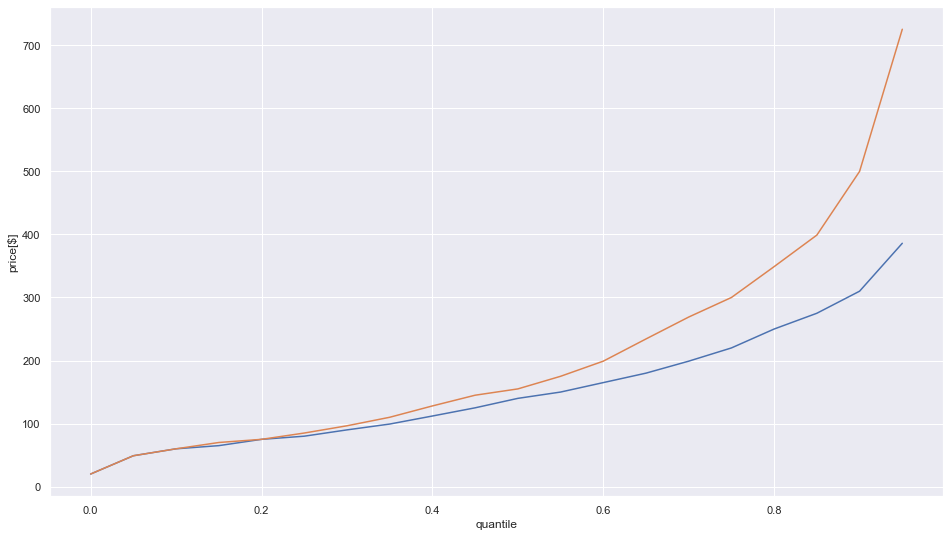

In [12]:
plt.figure(figsize=(16, 9))
x_range = np.arange(0, 1, 0.05)
plt.plot(x_range, [boston_price_diff['price_before'].quantile(x) for x in x_range])
plt.plot(x_range, [boston_price_diff['price_after'].quantile(x) for x in x_range])
plt.xlabel('quantile')
plt.ylabel('price[$]')
plt.show()

The lower 50% of rooms have not increased in price significantly.<br>
But, hte top 50%, especially the top 25%, are making big price gains.

## Price changes lower 50% and top 25%

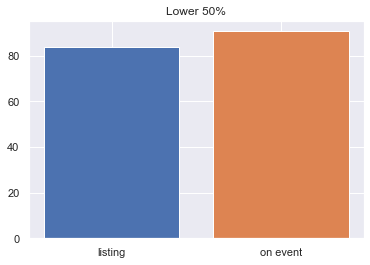

In [13]:
lower_before = boston_price_diff[boston_price_diff['price_before'] < boston_price_diff['price_before'].quantile(0.5)]['price_before'].mean()
lower_after = boston_price_diff[boston_price_diff['price_after'] < boston_price_diff['price_after'].quantile(0.5)]['price_after'].mean()
plt.title('Lower 50%')
plt.bar(['listing'], [lower_before.mean()])
plt.bar(['on event'], [lower_after.mean()])
plt.show()

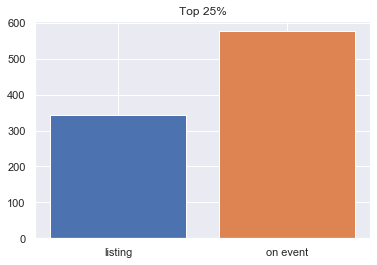

In [14]:
top_before = boston_price_diff[boston_price_diff['price_before'] > boston_price_diff['price_before'].quantile(0.75)]['price_before'].mean()
top_after = boston_price_diff[boston_price_diff['price_after'] > boston_price_diff['price_after'].quantile(0.75)]['price_after'].mean()
plt.title('Top 25%')
plt.bar(['listing'], [top_before.mean()])
plt.bar(['on event'], [top_after.mean()])
plt.show()

## Question 1 conclusion

The price spike due to the event was in rooms with listing prices as high as $200 or more.

# Question 2: What's the difference between high and low room?
Property type? num of beds? or other?

In [15]:
# bottom 25%
boston_bottom = boston_list[boston_list['price'] < boston_list['price'].quantile(0.25)]
# top 25%
boston_top = boston_list[boston_list['price'] > boston_list['price'].quantile(0.75)]

## Number of beds
There are obviously more beds.

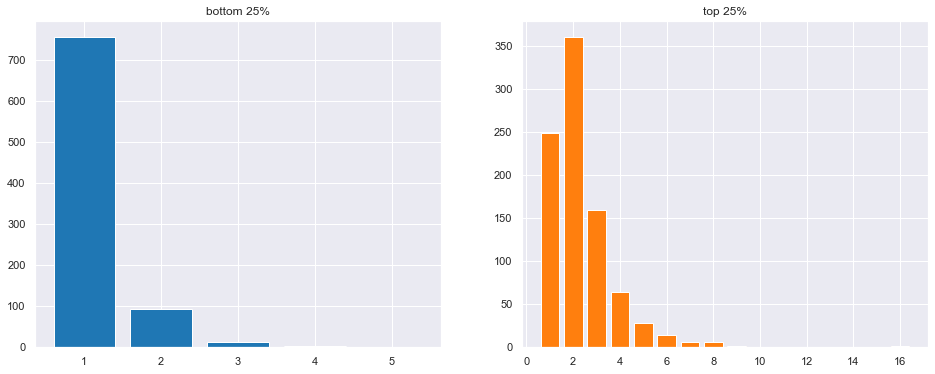

In [16]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
ax1.set_title('bottom 25%')
ax1.bar(boston_bottom['beds'].value_counts().index,
        boston_bottom['beds'].value_counts().values, color='tab:blue')

ax2 = plt.subplot(122)
ax2.set_title('top 25%')
ax2.bar(boston_top['beds'].value_counts().index,
        boston_top['beds'].value_counts().values, color='tab:orange')
plt.show()

## Number of accomodates
"Accomodates" is too.

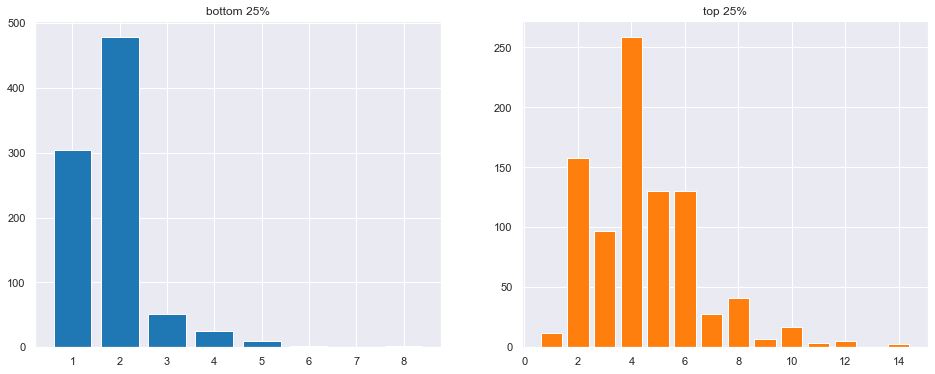

In [17]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
ax1.set_title('bottom 25%')
ax1.bar(boston_bottom['accommodates'].value_counts().index,
        boston_bottom['accommodates'].value_counts().values, color='tab:blue')

ax2 = plt.subplot(122)
ax2.set_title('top 25%')
ax2.bar(boston_top['accommodates'].value_counts().index,
        boston_top['accommodates'].value_counts().values, color='tab:orange')
plt.show()

## Top 5 of Property Type
Top 3 are same, Apartment, House and Condominium.

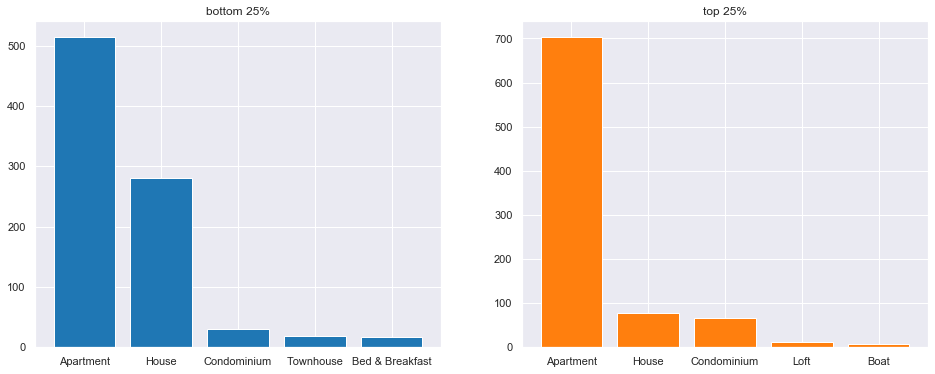

In [18]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
ax1.set_title('bottom 25%')
ax1.bar(boston_bottom['property_type'].value_counts().index[:5],
        boston_bottom['property_type'].value_counts().values[:5], color='tab:blue')

ax2 = plt.subplot(122)
ax2.set_title('top 25%')
ax2.bar(boston_top['property_type'].value_counts().index[:5],
        boston_top['property_type'].value_counts().values[:5], color='tab:orange')
plt.show()

## Room Type
There are significant difference.<br>
Bottom 25% rooms are mainly occupied by "Private room" but top 25% are "Entire home/apt".

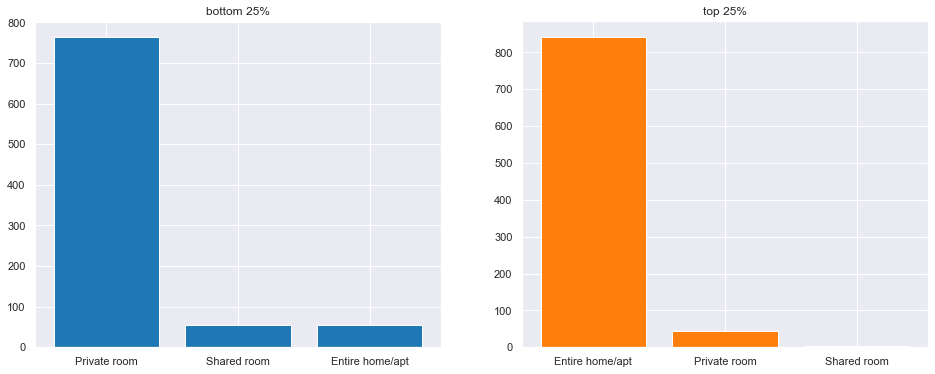

In [19]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
ax1.set_title('bottom 25%')
ax1.bar(boston_bottom['room_type'].value_counts().index,
        boston_bottom['room_type'].value_counts().values, color='tab:blue')

ax2 = plt.subplot(122)
ax2.set_title('top 25%')
ax2.bar(boston_top['room_type'].value_counts().index,
        boston_top['room_type'].value_counts().values, color='tab:orange')
plt.show()

## Question 2 conclusion
The difference in price was the size of the room.

Top 25% rooms are mainly entire home/apt and have many beds, so it can accommodate a lot of people.

# Question 3: What is the difference of Boston and Seattle
Is there a difference between Boston and Seattle, and if so, what is it?

## Number of rooms
It's almost same.

In [20]:
print('Boston  :', boston_list.shape[0])
print('Seattle :', seattle_list.shape[0])

Boston  : 3585
Seattle : 3818


## Price
Boston has more rooms over $100.

Show only under $500.

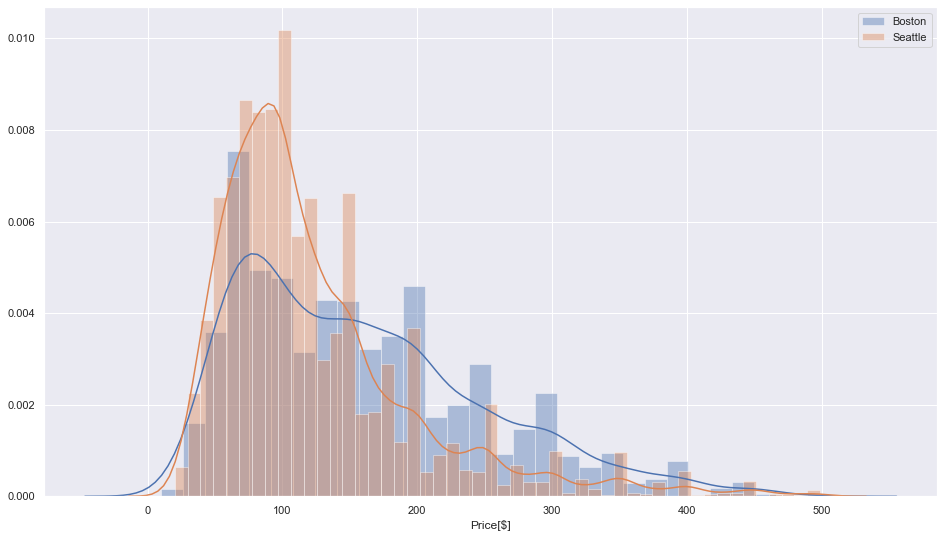

In [21]:
plt.figure(figsize=(16, 9))
sns.distplot(boston_list[boston_list['price'] < 500]['price'], label='Boston')
sns.distplot(seattle_list[seattle_list['price'] < 500]['price'], label='Seattle')
plt.legend()
plt.xlabel('Price[$]')
plt.show()

## What is the factor of the price
The price difference in Boston was the size of the room. <br>
So what is the reason for the difference between Boston and Seattle?

## Room Type
There are no difference betoween boston and seattle.

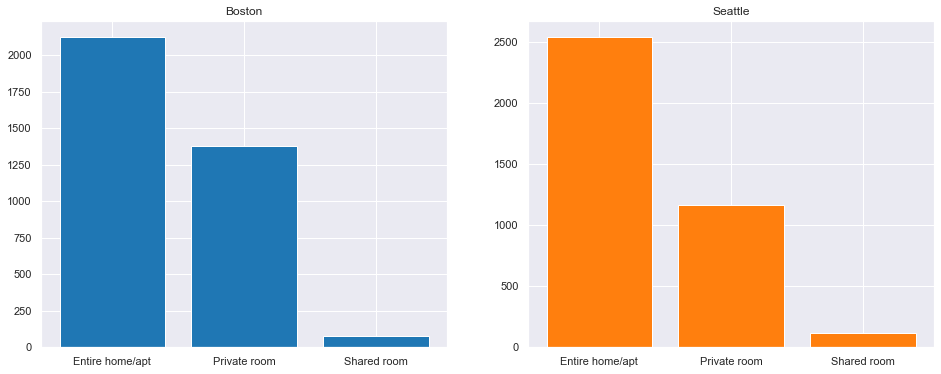

In [22]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
ax1.set_title('Boston')
ax1.bar(boston_list['room_type'].value_counts().index,
        boston_list['room_type'].value_counts().values, color='tab:blue')

ax2 = plt.subplot(122)
ax2.set_title('Seattle')
ax2.bar(seattle_list['room_type'].value_counts().index,
        seattle_list['room_type'].value_counts().values, color='tab:orange')
plt.show()

## Number of accomodates
There are no significant difference too.

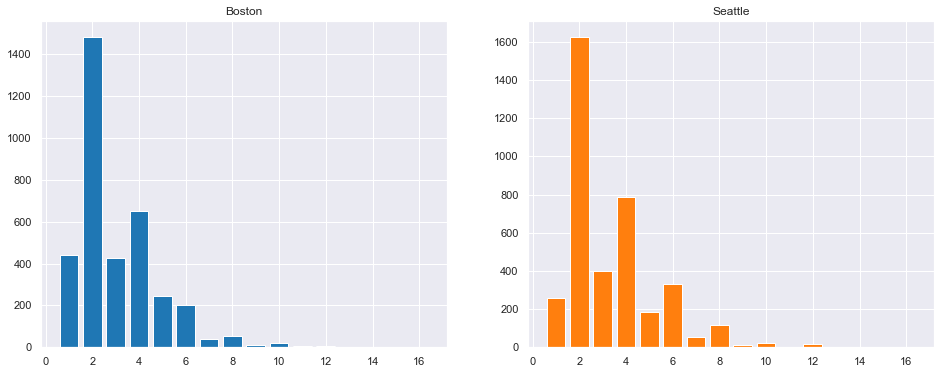

In [23]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
ax1.set_title('Boston')
ax1.bar(boston_list['accommodates'].value_counts().index,
        boston_list['accommodates'].value_counts().values, color='tab:blue')

ax2 = plt.subplot(122)
ax2.set_title('Seattle')
ax2.bar(seattle_list['accommodates'].value_counts().index,
        seattle_list['accommodates'].value_counts().values, color='tab:orange')
plt.show()

The size of the room does not seem to be related to the difference in price.<br>
So what is the Factor?

I think the original price of the house may be different.<br>
So I decided to look up the price of the house, but I don't know how to do that since I am Japanese and don't live in the US.

Therefore, I thought that if Boston is more urban than Seattle, the price of houses would be higher.

## Population and Density of Boston and Seattle
It's from Wikipedia.

[Boston]https://en.wikipedia.org/wiki/Boston

[Seattle]https://en.wikipedia.org/wiki/Seattle

In [24]:
boston_pop = 617594
boston_den = 5531.93
seattle_pop = 608660
seattle_den = 3464.55

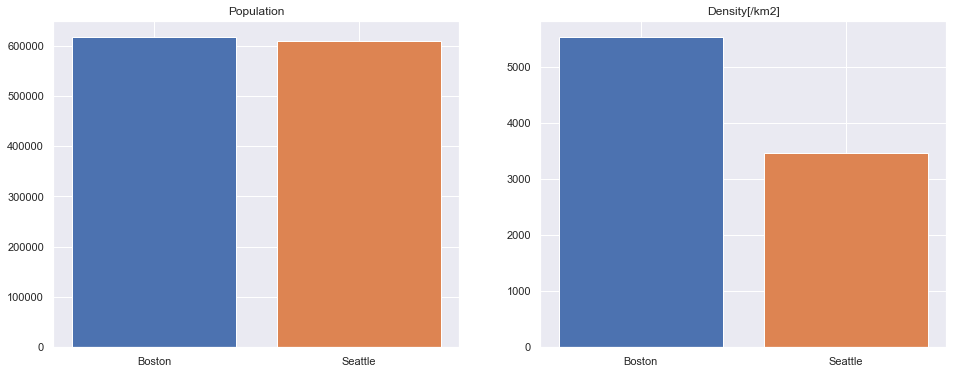

In [25]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
ax1.set_title('Population')
ax1.bar('Boston', boston_pop)
ax1.bar('Seattle', seattle_pop)

ax2 = plt.subplot(122)
ax2.set_title('Density[/km2]')
ax2.bar('Boston', boston_den)
ax2.bar('Seattle', seattle_den)

plt.show()

Population is almost same, but Boston is more densely populated.<br>
So that I think housing prices are higher in Boston.

# Question 3 conclusion
It was not possible to find out the actual housing prices.<br>

However, based on population density, Boston is considered to be more urban. 

Therefore, housing prices in Boston are expected to be higher.